In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve
import tensorflow_probability as tfp
from scipy.ndimage import gaussian_filter1d

### svhn experiments

In [6]:
# helper functions to create TF datasets

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.cast(image, tf.float32) / 255.
    # image = tf.reshape(image, (-1,))
    return image, label


def make_ds(ds):
    ds = ds.map(
        normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache()
    ds = ds.repeat()
    ds = ds.shuffle(int(1e5))
    ds = ds.batch(128)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [7]:
# create dataset, iterate over it and train, return model and metrics
class Trainer:
    
    def __init__(self, params):
        self.params = params
        print(f"\nRun training with params {self.params}")
        
        # create CIFAR dataset and get iterators
        ds_train, ds_test = out = tfds.load(
            'svhn',
            split=['train', 'test'],
            shuffle_files=True,
            as_supervised=True,
            with_info=False,
        )
        ds_train = make_ds(ds_train)
        ds_test = make_ds(ds_test)
        self.iter_train = iter(ds_train)
        self.iter_test = iter(ds_test)

        # define model
        self.model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=params['input_shape']),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(self.params['n_classes'], activation='softmax')])
        print(self.model.summary())

        # define optimizer
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.params['lr'])
        
        # maintain history
        self.history = []


    # define loss function
    # computes loss given a model and X, Y
    @tf.function
    def loss_fn(self, X, Y):
        Y_hat = self.model(X) 
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_true=Y, y_pred=Y_hat)
        accuracy = tf.reduce_mean(tf.cast(tf.argmax(Y_hat, axis=1) == Y, tf.float32)) * 100.
        entropy_on_original_point = tf.reduce_mean(-1.0 * tf.reduce_mean(Y_hat * tf.math.log(Y_hat), axis=1))

        if self.params['lambda'] == 0:
            return loss, 0., accuracy, entropy_on_original_point

        # Do PGD
        step_size = params['step_size']
        
        if self.params['version'] == 'min-max-cent':
            # compute gradient of cross entropy loss wrt X and take a step in -ve direction
            # this would try to find a point in the neighborhood of X that minimizes cross entropy
            with tf.GradientTape() as tape:
                tape.watch(X)
                Y_hat = self.model(X)
                loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_true=Y, y_pred=Y_hat)
            grads = tape.gradient(loss, X)
            grads_norm = tf.norm(tf.reshape(grads, (128, -1)), axis=1)
            grads = step_size * grads / grads_norm[:, None, None, None]
            entropy_on_original_point = tf.reduce_mean(-1.0 * tf.reduce_mean(Y_hat * tf.math.log(Y_hat), axis=1))
            X_perturbed = tf.clip_by_value(X + grads, 0.0, 1.0)
            # compute cross entropy at this new point
            Y_hat = self.model(X_perturbed)  
            loss_adv = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_true=Y, y_pred=Y_hat)
            return loss + self.params['lambda'] * loss_adv, loss_adv, accuracy, entropy_on_original_point

        elif self.params['version'] == 'max-min-ent':
            # compute grad of entropy wrt X and take a step in negative direction
            # this would find a point in the neighborhood of X that would minimize entropy
            with tf.GradientTape() as tape:
                tape.watch(X)
                Y_hat = self.model(X)
                entropy = -1.0 * tf.reduce_mean(Y_hat * tf.math.log(Y_hat), axis=1)
                entropy_on_original_point = tf.reduce_mean(entropy)
            grads = tape.gradient(entropy, X)
            grads_norm = tf.norm(tf.reshape(grads, (128, -1)), axis=1)
            grads = -step_size * grads / grads_norm[:, None, None, None]      
            X_perturbed = tf.clip_by_value(X + grads, 0.0, 1.0)
            # compute entropy at this new point and multiply it by -1, since we want to maximize entropy
            Y_hat = self.model(X_perturbed)
            entropy = -1.0 * tf.reduce_mean(Y_hat * tf.math.log(Y_hat), axis=1)
            loss_adv = -1.0 * tf.reduce_mean(entropy)
            return loss + self.params['lambda'] * loss_adv, loss_adv, accuracy, entropy_on_original_point
        
        elif self.params['version'] == 'min-max-KL-unif':
            # compute grad of KL(unif, p_\theta) wrt X and take a step in negative direction
            # this would find a point in the neighborhood of X that would maximize KL
            with tf.GradientTape() as tape:
                tape.watch(X)
                Y_hat = self.model(X)
                KL_unif = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(y_true=tf.ones_like(Y_hat) / params['n_classes'], y_pred=Y_hat)
            grads = tape.gradient(KL_unif, X)
            grads_norm = tf.norm(tf.reshape(grads, (128, -1)), axis=1)
            grads = step_size * grads / grads_norm[:, None, None, None]      
            entropy_on_original_point = tf.reduce_mean(-1.0 * tf.reduce_mean(Y_hat * tf.math.log(Y_hat), axis=1))
            X_perturbed = tf.clip_by_value(X + grads, 0.0, 1.0)
            # compute entropy at this new point and multiply it by -1, since we want to maximize entropy
            Y_hat = self.model(X_perturbed)
            KL_unif = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(y_true=tf.ones_like(Y_hat) / params['n_classes'], y_pred=Y_hat)
            loss_adv = tf.reduce_mean(KL_unif)
            return loss + self.params['lambda'] * loss_adv, loss_adv, accuracy, entropy_on_original_point

        
        else:
            raise ValueError


    # define step function
    # computes gradients and applies them
    @tf.function
    def step_fn(self, X_train, Y_train):
        with tf.GradientTape() as tape:
            loss, loss_adv, accuracy, predent = self.loss_fn(X_train, Y_train)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, loss_adv, accuracy, predent
    
    
    
    @tf.function
    def eval_ood_helper(self, X_real, X_fake):
        Y_hat_real = self.model(X_real)
        entropy_real = -1.0 * tf.reduce_mean(Y_hat_real * tf.math.log(Y_hat_real), axis=1)
        Y_hat_fake = self.model(X_fake)
        entropy_fake = -1.0 * tf.reduce_mean(Y_hat_fake * tf.math.log(Y_hat_fake), axis=1)
        return tf.concat([entropy_real, entropy_fake], axis=0)

    def eval_ood(self, X_real, X_fake):
        logits = trainer.eval_ood_helper(X_real, X_fake).numpy()
        labels = np.concatenate([np.zeros(128), np.ones(128)])
        auc = roc_auc_score(labels, logits)
        return auc

    @tf.function
    def get_calibration_metrics(self, X, Y):
        logits = tf.math.log(self.model(X))
        brier = tf.reduce_mean(tfp.stats.brier_score(labels=Y, logits=logits))
        ece = tfp.stats.expected_calibration_error(num_bins=20, logits=logits, labels_true=Y)
        nll = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(y_true=Y, y_pred=logits)
        return brier, ece, nll

        
    def train(self):
        
        # loop over data n_iters times
        for t in tqdm.trange(self.params['n_iters']):
            X_train, Y_train = next(self.iter_train)
            train_loss, train_loss_adv, train_acc, train_predent = self.step_fn(X_train, Y_train)
            if t % 10 == 0:
                X_test, Y_test = next(self.iter_test)
                test_loss, test_loss_adv, test_acc, test_predent = self.loss_fn(X_test, Y_test)
            self.history.append((train_loss.numpy(), test_loss.numpy(), train_acc.numpy(), test_acc.numpy(),
                                train_loss_adv.numpy(), test_loss_adv.numpy(), train_predent.numpy(), test_predent.numpy()))

        self.history = np.array(self.history)


In [8]:
# plotting utils

def plot_training_metrics(baseline_trainer, our_trainer, tags=['baseline', '']):
    
    trainer_vec = [baseline_trainer, our_trainer]
    
    c_vec = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.figure(figsize=(20, 3))
    
    # accuracy
    plt.subplot(1, 4, 1)
    plt.title("Train/Test accuracy")
    for idx, (c, trainer) in enumerate(zip(c_vec, trainer_vec)):
        name = tags[idx]
        plt.plot(gaussian_filter1d(trainer.history[:, 2], 100), '-o', c=c, label='%s - train' % name, markevery=1000, markersize=10)
        plt.plot(gaussian_filter1d(trainer.history[:, 3], 100), '-^', c=c, label='%s - val' % name, markevery=1000, markersize=10)
    plt.grid()
    plt.xlabel('iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # loss
    plt.subplot(1, 4, 2)
    plt.title("Train/Test cross entropy loss")
    for idx, (c, trainer) in enumerate(zip(c_vec, trainer_vec)):
        name = tags[idx]
        plt.plot(gaussian_filter1d(trainer.history[:, 0], 100), '-o', c=c, label='%s - train' % name, markevery=1000, markersize=10)
        plt.plot(gaussian_filter1d(trainer.history[:, 1], 100), '-^', c=c, label='%s - val' % name, markevery=1000, markersize=10)
    plt.grid()
    plt.xlabel('iterations')
    plt.ylabel('Loss')
    
    # adv loss
#     plt.subplot(1, 4, 3)
#     plt.title("Train/Test adversarial loss")
#     for idx, (c, trainer) in enumerate(zip(c_vec, trainer_vec)):
#         name = tags[idx]
#         plt.plot(np.abs(gaussian_filter1d(trainer.history[:, 4], 100)), '-o', c=c, label='%s - train' % name, markevery=1000, markersize=10)
#         plt.plot(np.abs(gaussian_filter1d(trainer.history[:, 5], 100)), '-^', c=c, label='%s - val' % name, markevery=1000, markersize=10)
#     plt.grid()
#     plt.xlabel('iterations')
#     plt.ylabel('Adv Loss')
    
    # adv loss
    plt.subplot(1, 4, 4)
    plt.title("Train/Test predictive entropy")
    for idx, (c, trainer) in enumerate(zip(c_vec, trainer_vec)):
        name = tags[idx]
        plt.plot(np.abs(gaussian_filter1d(trainer.history[:, 6], 100)), '-o', c=c, label='%s - train' % name, markevery=1000, markersize=10)
        plt.plot(np.abs(gaussian_filter1d(trainer.history[:, 7], 100)), '-^', c=c, label='%s - val' % name, markevery=1000, markersize=10)
    plt.grid()
    plt.xlabel('iterations')
    plt.ylabel('Entropy')
    
    plt.show()
    
    
    
def plot_OOD_metrics(results, tags):
    plt.figure(figsize=(12, 6))
    for (j, title) in enumerate(['Accuracy OOD $(\\uparrow)$', 'OOD AUC $(\\uparrow)$', 'Brier $(\\downarrow)$', 'ECE  $(\\downarrow)$', 'NLL  $(\\downarrow)$']):
        plt.subplot(2, 3, j + 1)
        plt.title(title)
        for idx in range(len(tags)):
            x = np.arange(len(corruption_type_list))
            y = [results[(ctype, idx)][j] for ctype in corruption_type_list]
            width = 0.25
            offset = width
            plt.bar(x + width * (idx + 1) - offset, y, width=width, label=f'{tags[idx]}')
        plt.xticks(np.arange(len(corruption_type_list)), corruption_type_list, rotation=90)
        plt.grid()
        if j == 0:
            plt.legend(fontsize=12, loc='lower right')
        
    plt.tight_layout()
    plt.show()

In [9]:
# baseline
params = {
    'input_shape': (32, 32, 3),
    'n_classes': 10,
    'lambda': 0.0,
    'lr': 5e-4,
    'step_size': 0.,
    'n_iters': 12000,
    'version': 'NA'
}
baseline_trainer = Trainer(params)
baseline_trainer.train()


# min max cross-entropy
params = {
    'input_shape': (32, 32, 3),
    'n_classes': 10,
    'lambda': 10.0,
    'lr': 5e-4,
    'step_size': 0.2,
    'n_iters': 12000,
    'version': 'min-max-cent'
}
min_max_cent_trainer = Trainer(params)
min_max_cent_trainer.train()



# max-min-ent
params = {
    'input_shape': (32, 32, 3),
    'n_classes': 10,
    'lambda': 10.0,
    'lr': 5e-4,
    'step_size': 0.2,
    'n_iters': 12000,
    'version': 'max-min-ent'
}
max_min_ent_trainer = Trainer(params)
max_min_ent_trainer.train()


# max min KL with unif
params = {
    'input_shape': (32, 32, 3),
    'n_classes': 10,
    'lambda': 10.,
    'lr': 5e-4,
    'step_size': 0.2,
    'n_iters': 12000,
    'version': 'max-min-KL-unif'
}
max_min_KL_unif_trainer = Trainer(params)
max_min_KL_unif_trainer.train()


Run training with params {'input_shape': (32, 32, 3), 'n_classes': 10, 'lambda': 0.0, 'lr': 0.0005, 'step_size': 0.0, 'n_iters': 12000, 'version': 'NA'}


DatasetNotFoundError: Dataset svhn not found.
Available datasets:
	- abstract_reasoning
	- accentdb
	- aeslc
	- aflw2k3d
	- ag_news_subset
	- ai2_arc
	- ai2_arc_with_ir
	- amazon_us_reviews
	- anli
	- arc
	- bair_robot_pushing_small
	- bccd
	- beans
	- big_patent
	- bigearthnet
	- billsum
	- binarized_mnist
	- binary_alpha_digits
	- blimp
	- bool_q
	- c4
	- caltech101
	- caltech_birds2010
	- caltech_birds2011
	- cars196
	- cassava
	- cats_vs_dogs
	- celeb_a
	- celeb_a_hq
	- cfq
	- cherry_blossoms
	- chexpert
	- cifar10
	- cifar100
	- cifar10_1
	- cifar10_corrupted
	- citrus_leaves
	- cityscapes
	- civil_comments
	- clevr
	- clic
	- clinc_oos
	- cmaterdb
	- cnn_dailymail
	- coco
	- coco_captions
	- coil100
	- colorectal_histology
	- colorectal_histology_large
	- common_voice
	- coqa
	- cos_e
	- cosmos_qa
	- covid19
	- covid19sum
	- crema_d
	- curated_breast_imaging_ddsm
	- cycle_gan
	- d4rl_adroit_door
	- d4rl_adroit_hammer
	- d4rl_adroit_pen
	- d4rl_adroit_relocate
	- d4rl_mujoco_ant
	- d4rl_mujoco_halfcheetah
	- d4rl_mujoco_hopper
	- d4rl_mujoco_walker2d
	- dart
	- davis
	- deep_weeds
	- definite_pronoun_resolution
	- dementiabank
	- diabetic_retinopathy_detection
	- div2k
	- dmlab
	- doc_nli
	- dolphin_number_word
	- downsampled_imagenet
	- drop
	- dsprites
	- dtd
	- duke_ultrasound
	- e2e_cleaned
	- efron_morris75
	- emnist
	- eraser_multi_rc
	- esnli
	- eurosat
	- fashion_mnist
	- flic
	- flores
	- food101
	- forest_fires
	- fuss
	- gap
	- geirhos_conflict_stimuli
	- gem
	- genomics_ood
	- german_credit_numeric
	- gigaword
	- glue
	- goemotions
	- gpt3
	- gref
	- groove
	- gtzan
	- gtzan_music_speech
	- hellaswag
	- higgs
	- horses_or_humans
	- howell
	- i_naturalist2017
	- imagenet2012
	- imagenet2012_corrupted
	- imagenet2012_multilabel
	- imagenet2012_real
	- imagenet2012_subset
	- imagenet_a
	- imagenet_r
	- imagenet_resized
	- imagenet_v2
	- imagenette
	- imagewang
	- imdb_reviews
	- irc_disentanglement
	- iris
	- kddcup99
	- kitti
	- kmnist
	- lambada
	- lfw
	- librispeech
	- librispeech_lm
	- libritts
	- ljspeech
	- lm1b
	- lost_and_found
	- lsun
	- lvis
	- malaria
	- math_dataset
	- mctaco
	- mlqa
	- mnist
	- mnist_corrupted
	- movie_lens
	- movie_rationales
	- movielens
	- moving_mnist
	- multi_news
	- multi_nli
	- multi_nli_mismatch
	- natural_questions
	- natural_questions_open
	- newsroom
	- nsynth
	- nyu_depth_v2
	- ogbg_molpcba
	- omniglot
	- open_images_challenge2019_detection
	- open_images_v4
	- openbookqa
	- opinion_abstracts
	- opinosis
	- opus
	- oxford_flowers102
	- oxford_iiit_pet
	- para_crawl
	- patch_camelyon
	- paws_wiki
	- paws_x_wiki
	- pet_finder
	- pg19
	- piqa
	- places365_small
	- plant_leaves
	- plant_village
	- plantae_k
	- protein_net
	- qa4mre
	- qasc
	- quac
	- quickdraw_bitmap
	- race
	- radon
	- reddit
	- reddit_disentanglement
	- reddit_tifu
	- ref_coco
	- resisc45
	- rlu_atari
	- rlu_dmlab_explore_object_rewards_few
	- rlu_dmlab_explore_object_rewards_many
	- rlu_dmlab_rooms_select_nonmatching_object
	- rlu_dmlab_rooms_watermaze
	- rlu_dmlab_seekavoid_arena01
	- robonet
	- rock_paper_scissors
	- rock_you
	- s3o4d
	- salient_span_wikipedia
	- samsum
	- savee
	- scan
	- scene_parse150
	- schema_guided_dialogue
	- scicite
	- scientific_papers
	- sentiment140
	- shapes3d
	- siscore
	- smallnorb
	- snli
	- so2sat
	- speech_commands
	- spoken_digit
	- squad
	- stanford_dogs
	- stanford_online_products
	- star_cfq
	- starcraft_video
	- stl10
	- story_cloze
	- summscreen
	- sun397
	- super_glue
	- svhn_cropped
	- symmetric_solids
	- tao
	- ted_hrlr_translate
	- ted_multi_translate
	- tedlium
	- tf_flowers
	- the300w_lp
	- tiny_shakespeare
	- titanic
	- trec
	- trivia_qa
	- tydi_qa
	- uc_merced
	- ucf101
	- vctk
	- visual_domain_decathlon
	- voc
	- voxceleb
	- voxforge
	- waymo_open_dataset
	- web_nlg
	- web_questions
	- wider_face
	- wiki40b
	- wiki_bio
	- wiki_table_questions
	- wiki_table_text
	- wikiann
	- wikihow
	- wikipedia
	- wikipedia_toxicity_subtypes
	- wine_quality
	- winogrande
	- wmt13_translate
	- wmt14_translate
	- wmt15_translate
	- wmt16_translate
	- wmt17_translate
	- wmt18_translate
	- wmt19_translate
	- wmt_t2t_translate
	- wmt_translate
	- wordnet
	- wsc273
	- xnli
	- xquad
	- xsum
	- xtreme_pawsx
	- xtreme_xnli
	- yelp_polarity_reviews
	- yes_no
	- youtube_vis

Check that:
    - if dataset was added recently, it may only be available
      in `tfds-nightly`
    - the dataset name is spelled correctly
    - dataset class defines all base class abstract methods
    - the module defining the dataset class is imported


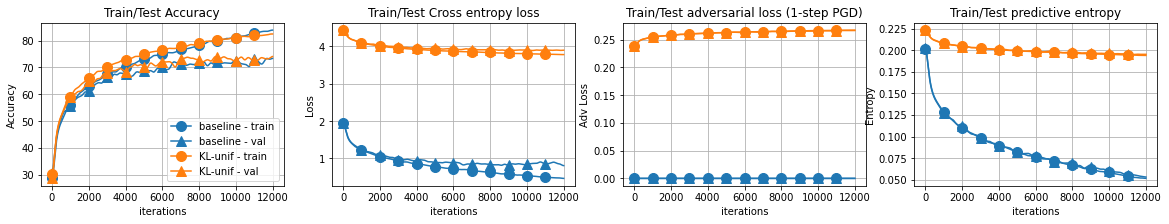

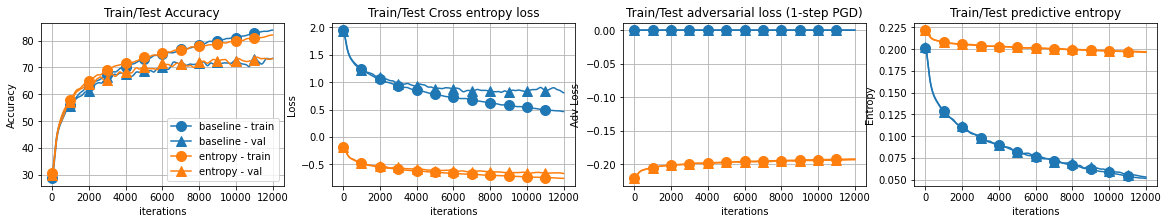

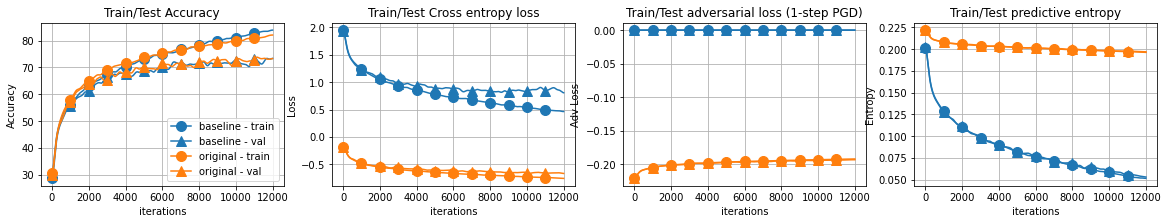

In [132]:
# plot
plot_training_metrics(baseline_trainer, min_max_cent_trainer, ['baseline', 'min-max-cent'])
plot_training_metrics(baseline_trainer, max_min_ent_trainer, ['baseline', 'max-min-ent'])
plot_training_metrics(baseline_trainer, min_max_KL_unif_trainer, ['baseline', 'min-max-KL-unif'])

Trainer 1
brightness_1


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 62.85it/s]


elastic_5


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 65.06it/s]


fog_5


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 63.91it/s]


frost_5


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 64.18it/s]


frosted_glass_blur_5


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 64.66it/s]


Trainer 2
brightness_1


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 66.72it/s]


elastic_5


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 65.27it/s]


fog_5


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 66.13it/s]


frost_5


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 65.57it/s]


frosted_glass_blur_5


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 66.71it/s]


Trainer 3
brightness_1


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 65.78it/s]


elastic_5


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 65.91it/s]


fog_5


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 66.39it/s]


frost_5


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 64.34it/s]


frosted_glass_blur_5


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 65.66it/s]


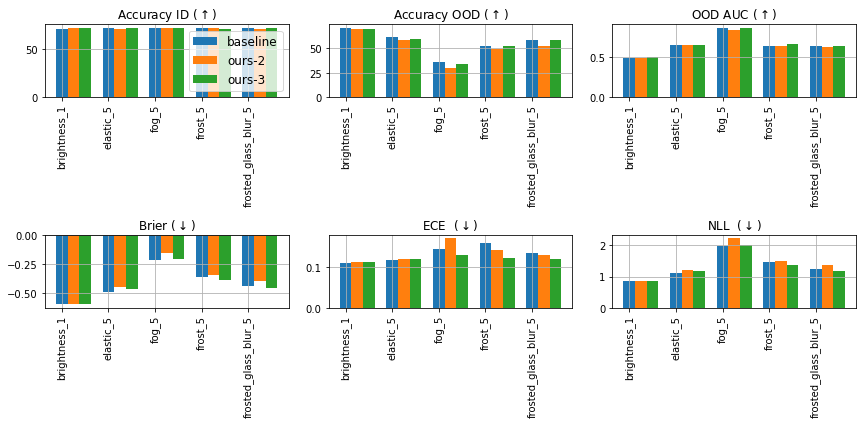

In [30]:
# compute OOD metrics
trainer_vec = [baseline_trainer, our_trainer_1, our_trainer_2]
results = {}
corruption_type_list = ['brightness_1', 'elastic_5', 'fog_5', 'frost_5', 'frosted_glass_blur_5']

for idx, trainer in enumerate(trainer_vec):
    print(f"Trainer {idx + 1}")
    for corruption_type in corruption_type_list:
        print(corruption_type)
        
        # load corrupted dataset
        (ds_corrupted,) = tfds.load(
            'cifar10_corrupted/%s' % corruption_type,
            split=['test'],
            shuffle_files=True,
            as_supervised=True,
            with_info=False,
        )
        
        # make dataset and get iterator
        ds_corrupted = make_ds(ds_corrupted)
        iter_corrupted = iter(ds_corrupted)

        # record metrics
        acc_OOD_vec = []
        auc_vec = []
        brier_vec = []
        ece_vec = []
        nll_vec = []
        
        # average over a 100 batches
        for _ in tqdm.trange(100):
            X_test, Y_test = next(trainer.iter_test)
            X_corrupted, Y_corrupted = next(iter_corrupted)
            _, _, test_acc_OOD = trainer.loss_fn(X_corrupted, Y_corrupted)
            test_auc = trainer.eval_ood(X_test, X_corrupted)
            brier, ece, nll = trainer.get_calibration_metrics(X_corrupted, Y_corrupted)

            acc_OOD_vec.append(test_acc_OOD.numpy())
            auc_vec.append(test_auc)
            brier_vec.append(brier.numpy())
            ece_vec.append(ece.numpy())
            nll_vec.append(nll.numpy())
        
        results[(corruption_type, idx)] = (np.mean(acc_OOD_vec), np.mean(auc_vec), np.mean(brier_vec), np.mean(ece_vec), np.mean(nll_vec))

plot_OOD_metrics(results)